# ML pipeline

##### this notebook puts together the different parts of the pipeline covered by the external files 
 the pipeline runs as follows: 
 - Data loading
 - Features engineering 
 - Train and validation 
 - Testing 
 - Plotting the results 
 


In [1]:
!git clone https://github.com/NazimTakhedmit/nio_assignement.git

Cloning into 'nio_assignement'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
cd nio_assignement/

/content/nio_assignement


### Data loading 

download the 911 calls file

In [3]:
!wget https://data.seattle.gov/api/views/kzjm-xkqj/rows.csv?accessType=DOWNLOAD

--2022-03-22 12:18:03--  https://data.seattle.gov/api/views/kzjm-xkqj/rows.csv?accessType=DOWNLOAD
Resolving data.seattle.gov (data.seattle.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.seattle.gov (data.seattle.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [                 <=>] 187.17M  1.64MB/s    in 2m 10s  

2022-03-22 12:20:14 (1.45 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [196258862]



In [4]:
# raw data name
raw_data_name = 'Seattle_Real_Time_Fire_911_Calls.csv'

In [5]:
#rename the file
import os 
os.rename('rows.csv?accessType=DOWNLOAD', 'Seattle_Real_Time_Fire_911_Calls.csv')

### Features engineering

In [6]:
!python features_engineering.py {raw_data_name}

date column split  ----Done
adding season column ----Done
adding the number of calls per day column ----Done
adding the number of calls per hour column ----Done
saving clean data ----Done


### Train and validation 

In [7]:
!pip3 install tensorflow_decision_forests

     |████████████████████████████████| 13.4 MB 3.8 MB/s 
     |████████████████████████████████| 462 kB 61.8 MB/s 


In [8]:
import tensorflow_decision_forests as tfdf
import pandas as pd
import shutil 
import numpy as np
import pickle

In [9]:
#read data
dataset_full = pd.read_csv("clean_data.csv")
dataset_full.columns

Index(['hour', 'day', 'month', 'year', 'date', 'season', 'calls_per_day',
       'calls_per_hour'],
      dtype='object')

In [10]:
#select the relevant columns for forecast
cols = ['hour', 'day', 'month', 'year', 'season', 'calls_per_hour']

dataset = dataset_full[cols]

In [11]:
#select training data as data of the five years before 2022
train_data = dataset[dataset.year.isin([2017, 2018, 2019, 2020, 2021])].reset_index()
train_data.head(4)
#test_data = dataset.

,index,hour,day,month,year,season,calls_per_hour
0,0,12,22,5,2019,Spring,15
1,1,12,22,5,2019,Spring,15
2,2,12,22,5,2019,Spring,15
3,3,7,1,7,2019,Summer,13


In [12]:
#select the current data (2022) as test data 
test_data = dataset[dataset.year == 2022].reset_index()
test_data.head(4)

,index,hour,day,month,year,season,calls_per_hour
0,640288,1,1,1,2022,Winter,20
1,672423,1,1,1,2022,Winter,20
2,973559,11,22,1,2022,Winter,11
3,1522286,1,1,1,2022,Winter,20


In [13]:
#serialize train and test data to be loaded by train and test files 
train_data.to_pickle("train_data.pkl")  
test_data.to_pickle("test_data.pkl")  

In [14]:
name_train = 'train_data.pkl'

In [15]:
#train the model
!python train.py {name_train}

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
2022-03-22 12:24:00.771640: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Use /tmp/tmp54q8qj80 as temporary training directory
Starting reading the dataset
Training tensor examples:
Features: {'index': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hour': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'day': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'month': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'year': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'season': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_6:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'inde

### testing

In [16]:
#test and evaluate the model 
!python test.py test_data.pkl

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
2022-03-22 12:26:35.881298: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine
25/25 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mean_absolute_error: 3.4359


### Plotting the results 

In [17]:
#load the model 
model = pickle.load(open('./model.sav', 'rb'))

In [18]:
#use test dataset to predict the call number and compare with real data 
test_ds  = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label='calls_per_hour',task=tfdf.keras.Task.REGRESSION)
np_result = np.array([x[0] for x in  model.predict(test_ds).astype(int)])

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [19]:
#create result dataframe as a copy of test data in order to append the prediction to it 
result = test_data.reset_index()

In [20]:
#add new column for the predicted values 
result['predicted'] = pd.DataFrame(list(np_result))

In [21]:
#create a summary dataset to visualize the results 
summary = result.groupby(['year','season','month','day'])['calls_per_hour','predicted'].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [22]:
#create a column for the weeks to help visualize the calls number per week per month 
summary['week'] = summary['day'].apply(lambda x: int(x/7)%4+1)

In [23]:
summary

,year,season,month,day,calls_per_hour,predicted,week
0,2022,Spring,3,21,4476,3809,4
1,2022,Spring,3,22,471,411,4
2,2022,Winter,1,1,6453,4581,1
3,2022,Winter,1,2,6691,4815,1
4,2022,Winter,1,3,5701,4643,1
...,...,...,...,...,...,...,...
76,2022,Winter,3,16,4145,4309,3
77,2022,Winter,3,17,4543,4750,3
78,2022,Winter,3,18,4598,4946,3
79,2022,Winter,3,19,4224,4556,3


In [24]:
#select data to plot i.e. month, week, real vs predicated calls number
data_plot =  summary.groupby(['month','week'])['calls_per_hour','predicted'].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [25]:
#combine the columns week and month to vizualize all the weeks and their respective months 
data_plot['m_w'] = data_plot['month']*10 + data_plot['week']

In [26]:
#convert the month_week column to string in order to be fully display in the x axis 
data_plot['m_w']=data_plot['m_w'].astype(str)

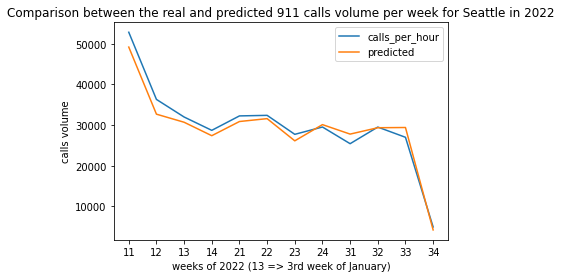

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p=sns.lineplot(x = 'm_w', y = 'calls_per_hour',data = data_plot)
p=sns.lineplot(x = 'm_w', y = 'predicted',data = data_plot)

p.set_xlabel("weeks of 2022 (13 => 3rd week of January)")
p.set_ylabel("calls volume")
p.set_title('Comparison between the real and predicted 911 calls volume per week for Seattle in 2022')
plt.legend(labels=["calls_per_hour","predicted"])